# Split the data

In [26]:
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import sys
sys.path.append("../src")
from reachability_model_holds_features_function import ReachabilityFeaturesGNN
from torch_geometric.data import Batch

In [21]:
# Load the Graphs
data = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_32256\1844560907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features.pt")


In [22]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Calculate the weights

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [24]:
weights

tensor([0.2439, 2.0707, 5.0000, 2.4208], device='cuda:0')

# Option 2: Use Balanced to calcualte the weights

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = np.concatenate([g.y.cpu().numpy() for g in train_data])  # 转为 numpy
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
weights

# Train the Model

In [25]:
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityFeaturesGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = CrossEntropyLoss(weight=weights)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 14338.6827
Epoch 2: Loss = 9967.1186
Epoch 3: Loss = 9872.5976
Epoch 4: Loss = 9790.8093
Epoch 5: Loss = 9750.3893
Epoch 6: Loss = 9722.5201
Epoch 7: Loss = 9693.5296
Epoch 8: Loss = 9671.5799
Epoch 9: Loss = 9653.3555
Epoch 10: Loss = 9629.5486
Epoch 11: Loss = 9613.3944
Epoch 12: Loss = 9609.7536
Epoch 13: Loss = 9590.7572
Epoch 14: Loss = 9594.3132
Epoch 15: Loss = 9556.3893
Epoch 16: Loss = 9548.5471
Epoch 17: Loss = 9524.1394
Epoch 18: Loss = 9541.8387
Epoch 19: Loss = 9508.2263
Epoch 20: Loss = 9543.8845
Epoch 21: Loss = 9481.1614
Epoch 22: Loss = 9466.6429
Epoch 23: Loss = 9465.5150
Epoch 24: Loss = 9479.3123
Epoch 25: Loss = 9460.0266
Epoch 26: Loss = 9420.7194
Epoch 27: Loss = 9399.8875
Epoch 28: Loss = 9328.0120
Epoch 29: Loss = 9315.3371
Epoch 30: Loss = 9308.4564
Epoch 31: Loss = 9295.2656
Epoch 32: Loss = 9282.9576
Epoch 33: Loss = 9320.5975
Epoch 34: Loss = 9284.7757
Epoch 35: Loss = 9268.3777
Epoch 36: Loss = 9256.9201
Epoch 37: Loss = 9268.1257
Epoch 38:

In [28]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device)     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({1: 3059407, 0: 2226231, 3: 1796984})


In [29]:
torch.save(model.state_dict(),"reachability_features_model.pt")

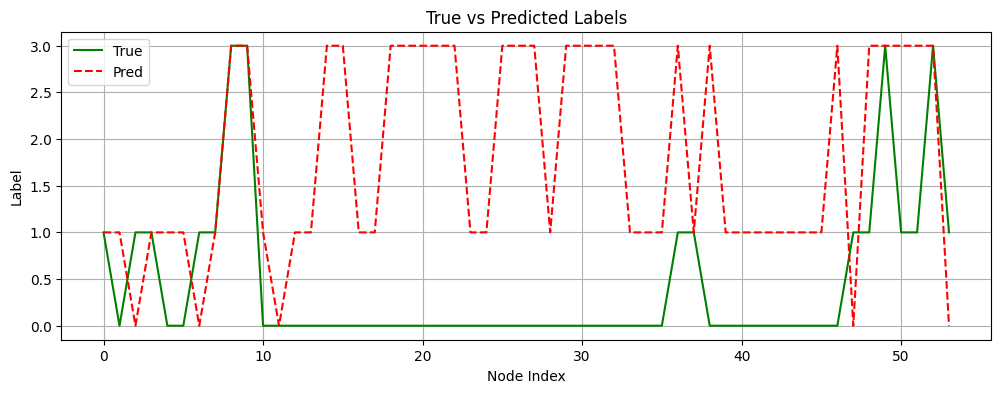

In [30]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [31]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

 unreachable       0.93      0.37      0.53   1376661
        hand       0.19      0.66      0.30    221572
        foot       0.00      0.00      0.00      2442
        both       0.16      0.47      0.24    155498

    accuracy                           0.41   1756173
   macro avg       0.32      0.37      0.27   1756173
weighted avg       0.77      0.41      0.47   1756173

